<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Training%20Deep%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks
Tackling a complex problem such as detecting hundreds of types of objects in high-resolution images requires a much deeper ANN, perhaps with 10 layers or many more, with each layer containing hundreds of neurons, linked by hundreds of thousands of connections.

Some problems that might occur are:
- Gradients growing smaller or larger, making lower layers very hard to trian
- Lack of training data for such a large network, or it might be too costly to label
- Training becomes extremely slow
- A model with millions of parameters would severely risk overfitting the trianing set, especially if there are not enough training instances of if they are too noisy

## The Vanishing/Exploding Gradients Problem
As the backpropagation algorithm progresses down to the lower layers, gradients often get smaller and smaller. As a result, the gradient descent update leaves the lower layers' connection weights virtually unchanged, causing the **Vanishing Gradients** problem.  
In some cases, the opposite happens: the gradients grow bigger and bigger until layers get insanely large weight updates, causing the **Exploding Gradients** problem.

### Glorot and He Initialization
**Glorot Initialization**:
- Balances the variance of activations between layers, preventing gradients from becoming too small or large
- Best for: Sigmoid, Tanh, Softmax

**He Initialization**:
- Focuses on deeper networks and accounts for ReLU activations, which have a different variance due to rectification
- Best for: ReLU and its variants

By default, Keras uses *Glorot Initialization* with a uniform distribution. However, it can be switched to *He Initilization* by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"`:

In [1]:
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

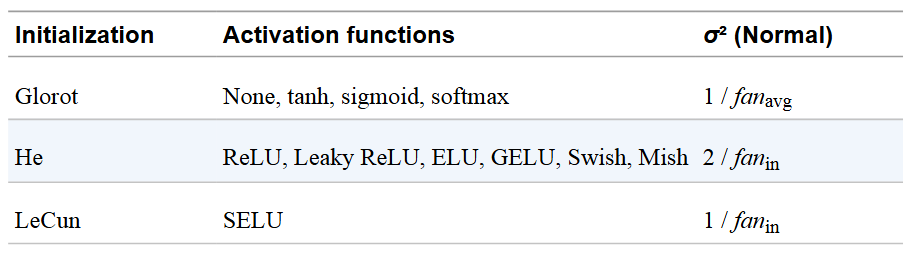
Alternatively, any of the initilizations above can be obtained using the `VarianceScaling` intializer. For example, to obtain a *He Initialization* with a uniform distribution and based on fan<sub>avg</sub>, use the following code:

In [2]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

### Better Activation Functions
Poor choice of activation function can lead to unstable gradients problems. The ReLU activation function is not perfect, it suffers from a problem known as "dying ReLUs": during training, some neurons effectively die, meaning that they stop outputting anything other than 0. A neuron dies when its weights get tweaked in a way that the input of the ReLU function is negative for all instances in the trianing set. To solve this issue, a variant of the ReLU function can be used, such as *Leaky ReLU*.

**Leaky ReLU** is defined as LeakyReLU<sub>α</sub>(z) = max(αz,z). The hyperparameter, α, determines how much the function leaks for z < 0. Having a z < 0 ensures that leaky ReLUs never dies.

**Parametric leaky ReLU (PReLU)**, where α is authorized to be learned during training: instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation. PReLU strongly outperforms ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

To use ReLU variants in Keras, *He Initilization* should be used:

In [3]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2) # default alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


For PReLU, replace LeakyReLU with PReLU.

### Batch Normalization
Although using *He Initialization* along ReLU or any of its variants can significantly reduce the danger of vanishing/exploding gradients problems at the beginning of the training, it does not guarantee that they won't come back during training.   <br><br>However, **Batch Normalization (BN)** addresses this problem. This technique consists of addressing an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using 2 new parameter vectors per layer: one for scaling, the other for shifting. If a BN layer is adding as the first layer of the Neural Network, standardization of the training set will no longer be required.

In [4]:
# Clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

### Gradient Clipping
Another technique to mitigate the exploding gradient problem is to clip the gradients during backpropagation so that they never exceed a certain threshold. This technique is generally used in recurrent neural networks, where using BN is tricky.

In Keras, implementing gradient clipping is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer:

In [6]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

This optimizer will clip every component of the gradient vector a value between -1.0 to 1.0. To ensure that gradient clipping does not change the direction of the gradient vector, use `clipnorm` instead of `clipvalue`.

In [7]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers
It is generally not a good idea to train a very large Deep Neural Network (DNN) from scratch without first finding an existing neural network that accomplishes a similar task. If such neural network is found, most of its layers can be reused, except for the top ones. This technique is called *Transfer Learning*. Not only does it speed up training considerably, but also requires significantly less training data.
<br><br>
Suppose a DNN that was trained to classify pictures into 100 different categories including plants, animals and every objects is obtained, and now the objective is to train a DNN to classify specific types of vehicles. Since both of these tasks are similar, the front few parts of the first network can be reused.
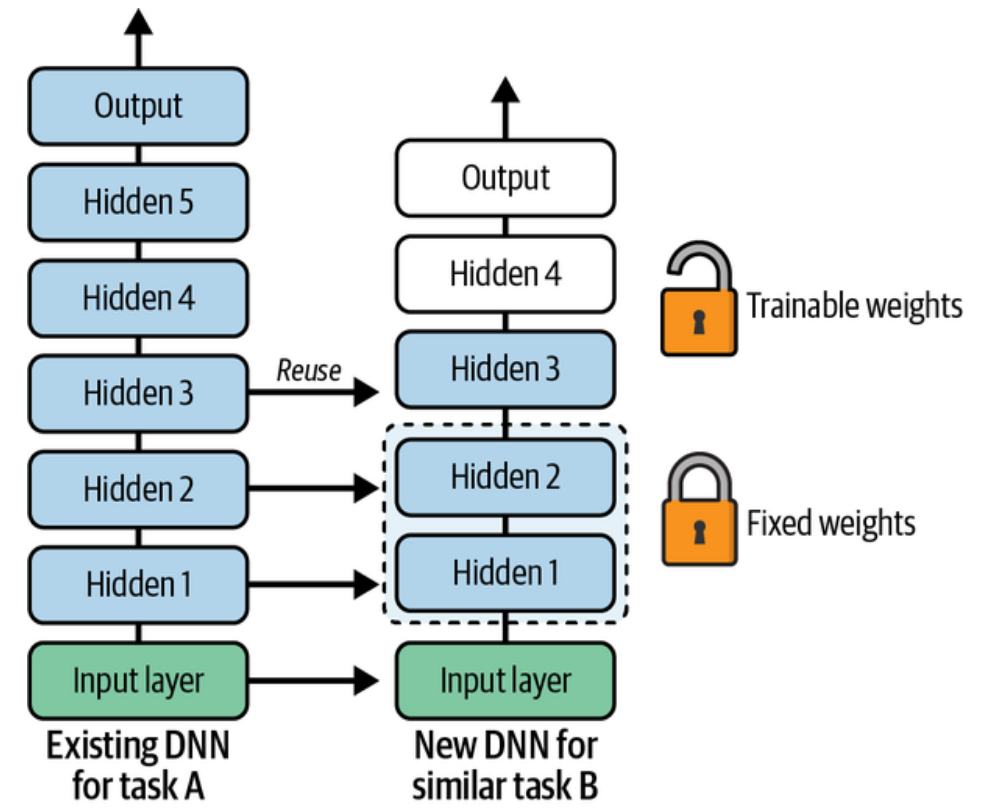

Try freezing all the reused layers first (i.e., make their weights non-trainable so that gradient descent does not modify them), then train the model and see how it performs. Then try unfreezing 1 or 2 of the top hidden layers to let backpropagation tweak them and see if the performance improves. The more training data available, the more layers can be unfreezed. Reducing the learning rate when unfreezing reused layers is also useful as this will avoid wrecking their fine-tuned weights.

### Transfer Learning with Keras
Suppose the Fashion MNIST dataset only contained 8 classes and someone has already built and trained a Keras model on that set and obtained a reasonably good performance (>90% accuracy), call this Model A:

Split the fashion MNIST training set in two:

- `X_train_A:` all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
- `X_train_B:` a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using Dense layers, only patterns that occur at the same location can be reused.

In [8]:
import numpy as np


# Load Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values (scale to 0-1 range)
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Split the training set into training and validation sets
X_train, X_valid = X_train_full[:50000], X_train_full[50000:]
y_train, y_valid = y_train_full[:50000], y_train_full[50000:]

# split Fashion MNIST into tasks A and B, then train and save model A to "my_model_A".
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5060 - loss: 1.5046 - val_accuracy: 0.7680 - val_loss: 0.7202
Epoch 2/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7905 - loss: 0.6622 - val_accuracy: 0.8306 - val_loss: 0.5321
Epoch 3/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8421 - loss: 0.5098 - val_accuracy: 0.8521 - val_loss: 0.4534
Epoch 4/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8611 - loss: 0.4387 - val_accuracy: 0.8618 - val_loss: 0.4091
Epoch 5/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8713 - loss: 0.3965 - val_accuracy: 0.8694 - val_loss: 0.3804
Epoch 6/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8784 - loss: 0.3679 - val_accuracy: 0.8761 - val_loss: 0.3600
Epoch 7/20
1251/1251 ━━━━━━━━━━

Suppose the new objective is to train a binary classifier: Positive for T-shirts and tops, Negative for sandals. After building and training a new model for this task, call it Model B, a 90.38% test accuracy is obtained:

In [9]:
# Train and evaluate model B, without reusing model A
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6435 - loss: 0.6638 - val_accuracy: 0.6893 - val_loss: 0.6428
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7104 - loss: 0.6309 - val_accuracy: 0.7691 - val_loss: 0.6125
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7698 - loss: 0.6017 - val_accuracy: 0.8104 - val_loss: 0.5854
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8109 - loss: 0.5749 - val_accuracy: 0.8351 - val_loss: 0.5608
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8641 - loss: 0.5502 - val_accuracy: 0.8523 - val_loss: 0.5386
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8658 - loss: 0.5276 - val_accuracy: 0.8690 - val_loss: 0.5179
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8921 - loss: 0.5067 - val_accuracy: 0.8823 - val_loss: 0.4988
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8958 - loss: 0.4873 - val_accuracy: 0.8887 - val_loss: 0.4813


[0.357460618019104, 0.9169999957084656]

However, since task B is quite similar to task A, try transfer learning to improve the performance:

In [10]:
model_A = tf.keras.models.load_model("my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that now model A and model B share some layers. So when we train one, it will update both models. To avoid that, we have to build "model_B_on_A" on top of a clone of "model_A":

In [11]:
tf.random.set_seed(42)

# Cloning model A
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

# Creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Now, we can train "model_B_on_A" for task B, but since the new output was initialized randomly, it will make large errors. To avoid this, one approach is to freeze the reused layers during the first few epochs. To do so, set every layer's `trainable` attribute to "False" and compile the model:

In [12]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

Now we can train the model for a few epochs, then unfreeze the reused layers and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually ideal to reduce the training rate, to avoid damaging the reused weights.

In [13]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4350 - loss: 3.0301 - val_accuracy: 0.4968 - val_loss: 2.0864
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4400 - loss: 2.0565 - val_accuracy: 0.4948 - val_loss: 1.3537
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4467 - loss: 1.3143 - val_accuracy: 0.4638 - val_loss: 0.9940
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4081 - loss: 0.9884 - val_accuracy: 0.3831 - val_loss: 0.8998
Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3467 - loss: 0.8699 - val_accuracy: 0.4609 - val_loss: 0.7592
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4590 - loss: 0.7328 - val_accuracy: 0.5771 - val_loss: 0.6646
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5980 - loss: 0.6411 - val_accuracy: 0.6903 - val_loss: 0.5947
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7103 - loss: 0.5729 - val_accuracy: 0.7627 - val_loss: 0.5407
Epoc

In [14]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9154 - loss: 0.3200


[0.3200637996196747, 0.9169999957084656]

This model's test accuracy has now improved to 93.65%.

## Faster Optimizers
### Momentum
Momentum optimization improves optimization speed by accelerating parameter updates in consistent gradient directions and reducing oscillations in steep, narrow regions of the loss surface. By accumulating a moving average of past gradients, it helps the optimizer maintain momentum in directions with persistent downward slopes, allowing it to cover flat regions more quickly. This reduces the number of steps needed to reach the minimum. Additionally, momentum dampens oscillations in directions of high curvature, which would otherwise slow down the optimizer. The combination of faster downhill movement and smoother updates leads to significantly improved convergence speed compared to standard gradient descent.<br>
**Momentum Algorithm**:<br>
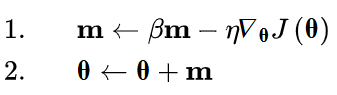








Implementation of momentum Optimization in Keras (momentum is usually set to 0.9):

In [15]:
# A Function to test an optimizer on Fashion MNIST
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [17]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6694 - loss: 1.0314 - val_accuracy: 0.8126 - val_loss: 0.5334
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8291 - loss: 0.4825 - val_accuracy: 0.8396 - val_loss: 0.4622
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8484 - loss: 0.4274 - val_accuracy: 0.8502 - val_loss: 0.4322
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8574 - loss: 0.3986 - val_accuracy: 0.8565 - val_loss: 0.4096
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8645 - loss: 0.3784 - val_accuracy: 0.8607 - val_loss: 0.3969
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8692 - loss: 0.3632 - val_accuracy: 0.8644 - val_loss: 0.3869
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8730 - loss: 0.3507 - val_accuracy: 0.8678 - val_loss: 0.3782
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8770 - loss: 0.3394 -

### Nesterov Accelerated Gradient (NAG)
Nesterov Accelerated Gradient (NAG) is an improvement over standard momentum optimization that provides faster convergence and better control over updates. Unlike traditional momentum, where the gradient is calculated at the current position, NAG looks ahead by estimating the future position of the parameters and computes the gradient at that point. This "lookahead" mechanism allows the optimizer to adjust its trajectory more accurately, reducing the risk of overshooting and improving responsiveness to changes in the loss surface. By combining this foresight with accumulated momentum, NAG achieves faster and smoother optimization, especially in complex, high-dimensional problems.<br>**Regular vs Nesterov Momentum Optimization:** <br>
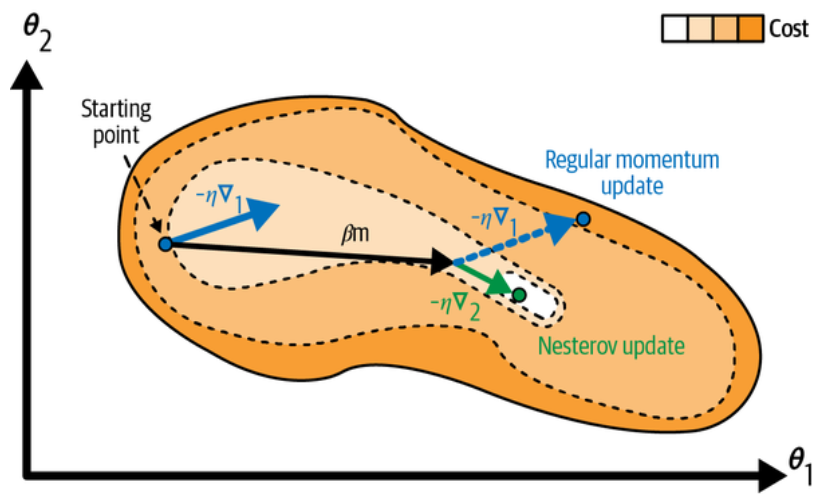
**NAG Algorithm:**<br>
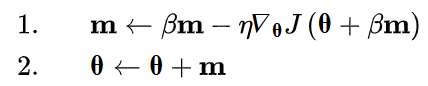

Implementation of NAG in Keras (learning rate and momentum are usually set to 0.001 and 0.9 respectively):

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [19]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6579 - loss: 1.0321 - val_accuracy: 0.8170 - val_loss: 0.5241
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8318 - loss: 0.4793 - val_accuracy: 0.8396 - val_loss: 0.4568
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8501 - loss: 0.4260 - val_accuracy: 0.8494 - val_loss: 0.4276
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8600 - loss: 0.3972 - val_accuracy: 0.8577 - val_loss: 0.4090
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8664 - loss: 0.3771 - val_accuracy: 0.8636 - val_loss: 0.3934
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8709 - loss: 0.3608 - val_accuracy: 0.8676 - val_loss: 0.3813
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8749 - loss: 0.3472 - val_accuracy: 0.8709 - val_loss: 0.3723
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8790 - loss: 0.3356 -

### AdaGrad (Adaptive Gradient Algorithm)
  AdaGrad is an optimization method that adjusts the learning rate for each parameter individually based on the magnitude of past gradients. Parameters that receive frequent updates have their learning rates reduced, while parameters with infrequent updates retain higher learning rates. This allows Adagrad to handle sparse data efficiently and adapt to different features at different rates. However, because the accumulated gradients grow over time, the learning rate can become excessively small, causing the optimizer to slow down or stop learning. To address this, variations like AdaDelta and RMSProp were introduced to limit this decay effect.
  <br>**AdaGrad vs Gradient Descent:** <br>
  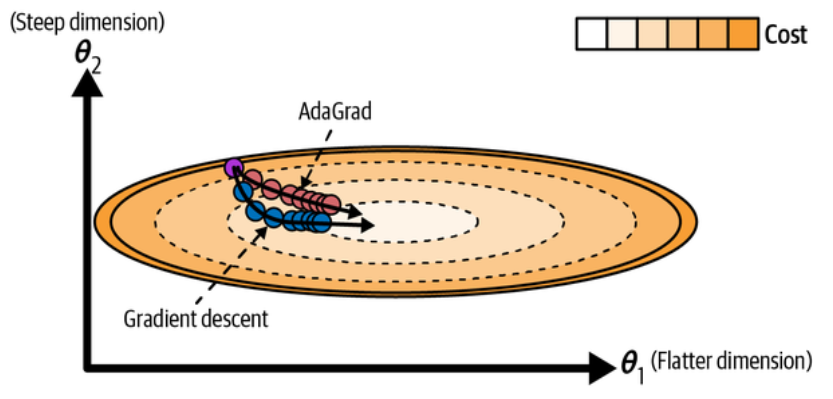
  <br>**AdaGrad Algorithm:**<br>
  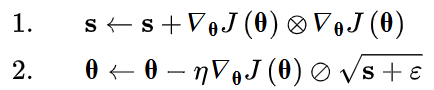

In [20]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [21]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5637 - loss: 1.3922 - val_accuracy: 0.7592 - val_loss: 0.7180
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7709 - loss: 0.6809 - val_accuracy: 0.7888 - val_loss: 0.6152
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7962 - loss: 0.5933 - val_accuracy: 0.8015 - val_loss: 0.5703
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8101 - loss: 0.5510 - val_accuracy: 0.8110 - val_loss: 0.5427
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8212 - loss: 0.5237 - val_accuracy: 0.8166 - val_loss: 0.5236
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8274 - loss: 0.5040 - val_accuracy: 0.8222 - val_loss: 0.5091
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8329 - loss: 0.4887 - val_accuracy: 0.8258 - val_loss: 0.4979
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8367 - loss: 0.4770 

### RMSProp (Root Mean Square Propagation)
RMSProp is an adaptive optimization algorithm that adjusts the learning rate for each parameter by scaling it based on a moving average of squared gradients. It keeps track of recent gradients using an exponentially decaying average, which prevents the learning rate from becoming excessively small over time, a key issue in Adagrad. This ensures the optimizer remains effective throughout training, especially on non-stationary and noisy problems. RMSProp is particularly useful for handling mini-batch updates in deep learning and works well for recurrent neural networks. A typical learning rate for RMSProp is 0.001, with a decay factor around 0.9.<br>**RMSProp Algorithm:**<br>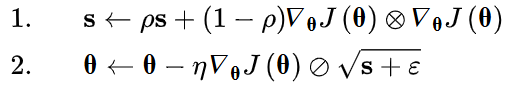

In [22]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [23]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7572 - loss: 0.6650 - val_accuracy: 0.8510 - val_loss: 0.4125
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8541 - loss: 0.4012 - val_accuracy: 0.8613 - val_loss: 0.3805
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8655 - loss: 0.3673 - val_accuracy: 0.8659 - val_loss: 0.3896
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8734 - loss: 0.3522 - val_accuracy: 0.8647 - val_loss: 0.4089
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8791 - loss: 0.3395 - val_accuracy: 0.8726 - val_loss: 0.4013
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8822 - loss: 0.3367 - val_accuracy: 0.8687 - val_loss: 0.4046
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8853 - loss: 0.3287 - val_accuracy: 0.8662 - val_loss: 0.4570
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8864 - loss: 0.3329 

Adam (Adaptive Moment Estimation)
Adam is a widely used optimization algorithm that combines the benefits of both momentum and RMSProp. It maintains two moving averages: one for the gradients (first moment) to accelerate convergence and another for the squared gradients (second moment) to adapt the learning rate for each parameter. Adam includes bias correction to ensure these estimates are unbiased early in training. It works well with noisy data and complex loss surfaces, making it suitable for a wide range of machine learning tasks, especially deep learning. The default learning rate is typically 0.001, with recommended values of β₁ = 0.9 (momentum) and β₂ = 0.999 (squared gradient decay).<br>
**Adam Algorithm:**<br>
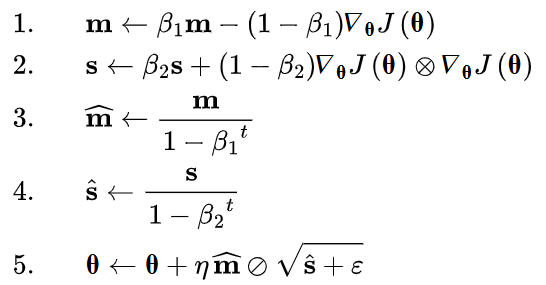


In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [25]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7709 - loss: 0.6518 - val_accuracy: 0.8481 - val_loss: 0.4148
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8565 - loss: 0.3879 - val_accuracy: 0.8686 - val_loss: 0.3668
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8702 - loss: 0.3472 - val_accuracy: 0.8712 - val_loss: 0.3555
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8777 - loss: 0.3230 - val_accuracy: 0.8724 - val_loss: 0.3607
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8857 - loss: 0.3052 - val_accuracy: 0.8788 - val_loss: 0.3570
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8912 - loss: 0.2871 - val_accuracy: 0.8725 - val_loss: 0.3658
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8958 - loss: 0.2741 - val_accuracy: 0.8715 - val_loss: 0.3857
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9012 - loss: 0.26

### AdaMax
AdaMax is a variant of the Adam optimizer based on the infinity norm (maximum absolute value) of the gradients instead of the second moment (mean squared gradients). It simplifies Adam’s update rule by replacing the
β₂-weighted moving average of squared gradients with the maximum of past gradients. This makes Adamax more robust to large gradient values and helps maintain stable learning rates even in the presence of extreme updates. It is particularly effective for models with very large parameter spaces. The default learning rate is 0.001, with
β₁=0.9 and
β₂=0.999, similar to Adam.

In [26]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [27]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7497 - loss: 0.7261 - val_accuracy: 0.8436 - val_loss: 0.4480
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8493 - loss: 0.4191 - val_accuracy: 0.8551 - val_loss: 0.4055
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8661 - loss: 0.3734 - val_accuracy: 0.8644 - val_loss: 0.3819
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8733 - loss: 0.3474 - val_accuracy: 0.8670 - val_loss: 0.3692
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8794 - loss: 0.3268 - val_accuracy: 0.8734 - val_loss: 0.3542
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8862 - loss: 0.3100 - val_accuracy: 0.8784 - val_loss: 0.3428
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8918 - loss: 0.2955 - val_accuracy: 0.8792 - val_loss: 0.3417
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8957 - loss: 0.2832 

### Nadam (Nesterov-accelerated Adaptive Moment Estimation)
Nadam is an extension of the Adam optimizer that incorporates Nesterov momentum into Adam’s update rule. While Adam adjusts learning rates using first and second moment estimates of gradients, Nadam goes further by applying Nesterov’s “lookahead” mechanism, which calculates gradients at a future position rather than the current one. This lookahead feature helps the optimizer better anticipate parameter updates, leading to faster convergence and more stable performance in deep learning models. Nadam typically uses a default learning rate of 0.001 with momentum parameters
β₁=0.9 and
β₂=0.999, similar to Adam.

In [28]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [29]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7841 - loss: 0.6197 - val_accuracy: 0.8621 - val_loss: 0.3883
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8611 - loss: 0.3758 - val_accuracy: 0.8621 - val_loss: 0.3747
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8758 - loss: 0.3376 - val_accuracy: 0.8704 - val_loss: 0.3556
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8838 - loss: 0.3132 - val_accuracy: 0.8717 - val_loss: 0.3529
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8904 - loss: 0.2963 - val_accuracy: 0.8809 - val_loss: 0.3323
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8963 - loss: 0.2786 - val_accuracy: 0.8790 - val_loss: 0.3435
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9010 - loss: 0.2664 - val_accuracy: 0.8760 - val_loss: 0.3474
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9031 - loss: 0.2553

###AdamW (Adam with Weight Decay)
AdamW is a variant of the Adam optimizer that decouples L2 regularization (weight decay) from the gradient updates. In standard Adam, weight decay is applied indirectly through the gradient calculation, which can lead to undesirable interactions between regularization and optimization. AdamW addresses this by applying weight decay directly to the parameters after the gradient update, ensuring that the learning dynamics remain unaffected by regularization. This improves generalization and stability, especially in deep learning models.

In [30]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [31]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7654 - loss: 0.6591 - val_accuracy: 0.8322 - val_loss: 0.4671
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8547 - loss: 0.3921 - val_accuracy: 0.8610 - val_loss: 0.3813
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8705 - loss: 0.3488 - val_accuracy: 0.8673 - val_loss: 0.3593
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8804 - loss: 0.3210 - val_accuracy: 0.8774 - val_loss: 0.3444
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8847 - loss: 0.3033 - val_accuracy: 0.8764 - val_loss: 0.3472
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8908 - loss: 0.2866 - val_accuracy: 0.8811 - val_loss: 0.3352
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8948 - loss: 0.2726 - val_accuracy: 0.8782 - val_loss: 0.3504
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9016 - loss: 0.2607

### Optimizer Comparison
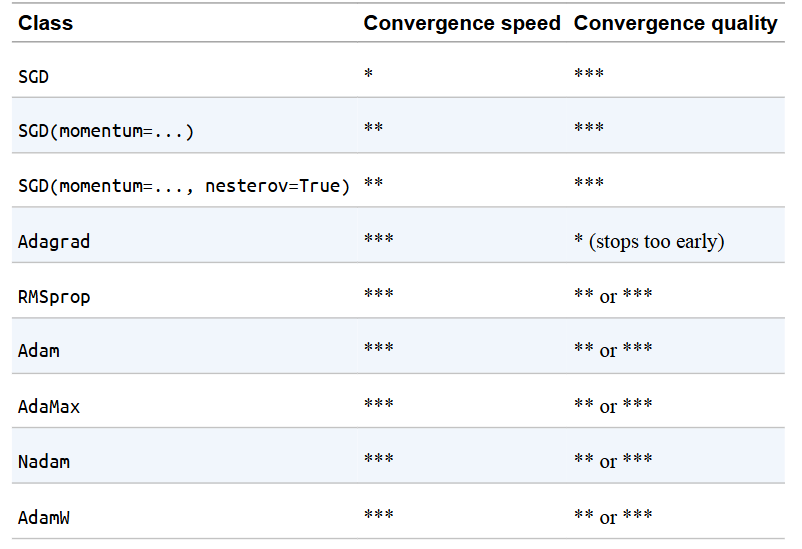
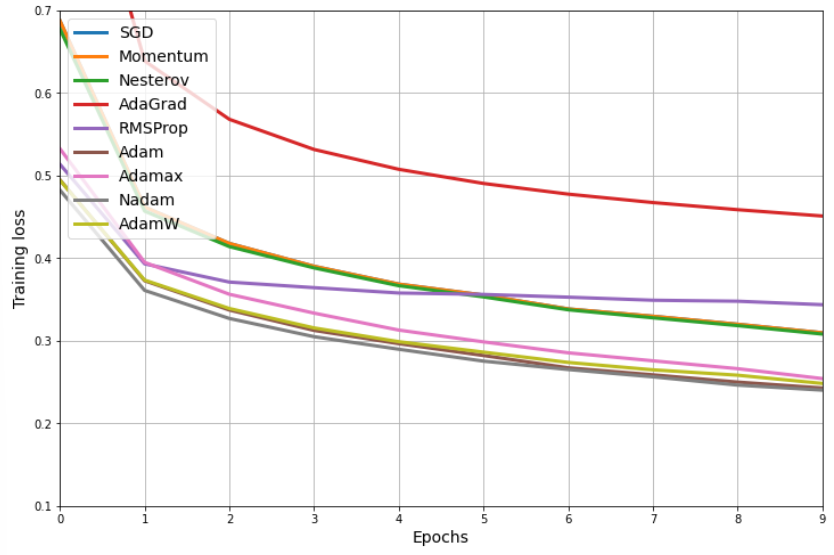
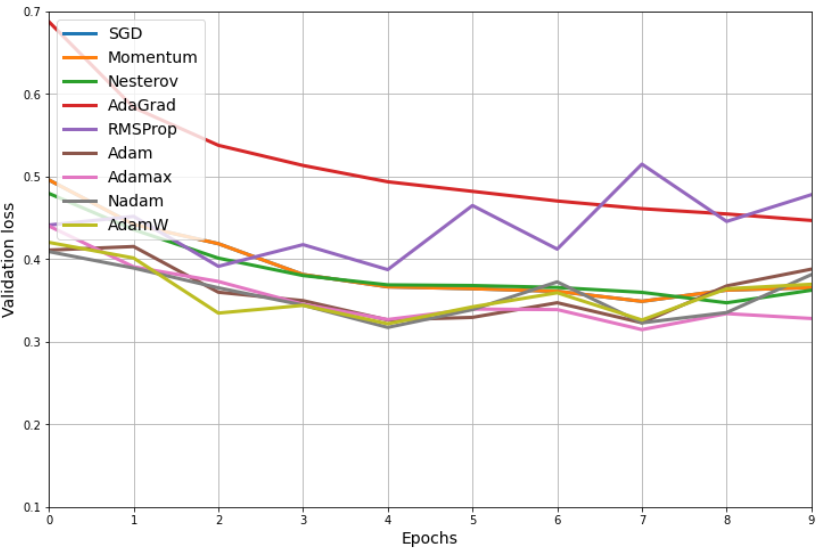

## Learning Rate Scheduling
Find a good learning rate is crucial. If its too high, training may diverge. If its too low, training will converge to the optimum, but will take a very long time. If the learning rate is set slightly too high, it will make progress very quickly at first, but will end up dancing around the optimum and will never settle down. <br>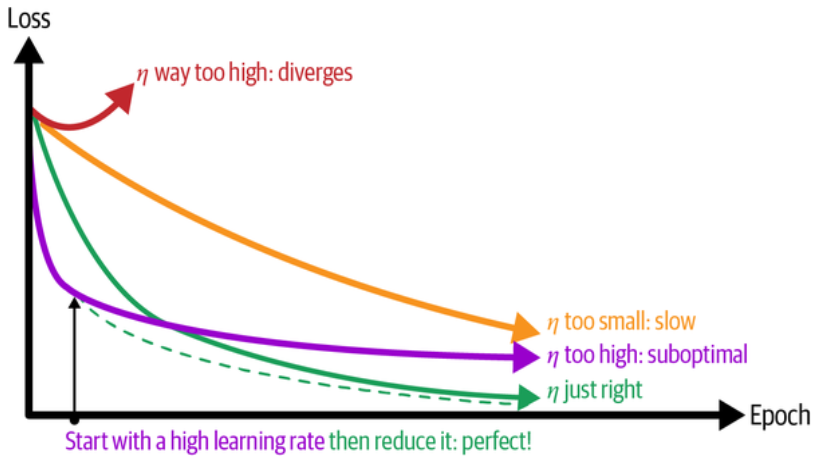

There are many different strategies to reduce the learning rate during training. It can also be beneficial to start off with a low learning rate, increase it, then drop it again. These strategies are called *Learning Schedules* and the most commonly used Learning schedules are:

#### 1) Power Scheduling:
Power scheduling is a learning rate decay technique that adjusts the learning rate over time based on a power-law function. The learning rate at step \( t \) is updated using the formula:

$$
\eta_t = \frac{\eta_0}{(1 + kt)^p}
$$

where:
- $\eta_0$ is the initial learning rate,
- \( k \) is a constant that controls the decay rate,
- \( p \) is the power factor that determines how quickly the learning rate decreases.

This method slows down parameter updates as training progresses, improving convergence and reducing the risk of overshooting the optimal solution. Power scheduling is particularly useful in scenarios where a constant learning rate would cause instability or prevent the model from reaching an optimal state.






In [32]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [33]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6676 - loss: 0.9998 - val_accuracy: 0.8182 - val_loss: 0.5198
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8282 - loss: 0.4898 - val_accuracy: 0.8416 - val_loss: 0.4570
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8444 - loss: 0.4371 - val_accuracy: 0.8523 - val_loss: 0.4300
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8536 - loss: 0.4092 - val_accuracy: 0.8569 - val_loss: 0.4121
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8605 - loss: 0.3905 - val_accuracy: 0.8607 - val_loss: 0.3987
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8653 - loss: 0.3767 - val_accuracy: 0.8635 - val_loss: 0.3895
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8693 - loss: 0.3655 - val_accuracy: 0.8647 - val_loss: 0.3816
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8720 - loss: 0.3563 - 

#### 2) Exponential scheduling:
Exponential scheduling is a learning rate decay technique that reduces the learning rate exponentially over time. The learning rate at step \( t \) is updated using the formula:

$$
\eta_t = \eta_0 \cdot e^{-kt}
$$

where:
- $\eta_0$ is the initial learning rate,
- \( k \) is a constant that controls the rate of decay,
- \( t \) is the current training step or epoch.

This method reduces the learning rate rapidly in the beginning, allowing the model to make large updates in early training and then slowly reduces the learning rate as training progresses. Exponential scheduling is effective for scenarios where you want to quickly converge early on and fine-tune the model in later stages.



In [34]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [35]:
history_exponential_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6870 - loss: 0.9498 - val_accuracy: 0.8211 - val_loss: 0.5182
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8294 - loss: 0.4842 - val_accuracy: 0.8422 - val_loss: 0.4555
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8472 - loss: 0.4312 - val_accuracy: 0.8520 - val_loss: 0.4253
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8571 - loss: 0.4040 - val_accuracy: 0.8571 - val_loss: 0.4094
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8636 - loss: 0.3865 - val_accuracy: 0.8594 - val_loss: 0.3991
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8685 - loss: 0.3740 - val_accuracy: 0.8619 - val_loss: 0.3919
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8720 - loss: 0.3646 - val_accuracy: 0.8651 - val_loss: 0.3860
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8743 - loss: 0.3572 

#### 3) Piecewise constant scheduling:
Piecewise constant scheduling is a learning rate decay technique where the learning rate remains constant within predefined intervals, but decreases at the start of each new interval. The learning rate at step \( t \) is defined as:

$$
\eta_t = \eta_i \quad \text{for} \quad t \in [T_i, T_{i+1})
$$

where:
- $\eta_i$ is the learning rate at interval \( i \),
- $T_i$ is the start step of the \( i \)-th interval,
- $T_{i+1}$ is the end step of the \( i \)-th interval.

The learning rate is typically reduced after each interval, allowing the optimizer to explore quickly in the early stages and then refine its search as it approaches the optimal solution. This method is especially useful when training is done in phases, such as for fine-tuning or transfer learning.


In [36]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [37]:
history_piecewise_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6837 - loss: 0.9568 - val_accuracy: 0.8196 - val_loss: 0.5171
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8275 - loss: 0.4871 - val_accuracy: 0.8464 - val_loss: 0.4399
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8459 - loss: 0.4294 - val_accuracy: 0.8546 - val_loss: 0.4128
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8560 - loss: 0.3987 - val_accuracy: 0.8600 - val_loss: 0.3953
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8640 - loss: 0.3775 - val_accuracy: 0.8636 - val_loss: 0.3840
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8685 - loss: 0.3616 - val_accuracy: 0.8664 - val_loss: 0.3740
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8739 - loss: 0.3486 - val_accuracy: 0.8696 - val_loss: 0.3648
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8778 - loss: 0.3372 -

#### 4) Performance scheduling
Performance scheduling is a learning rate decay technique where the learning rate is adjusted based on the model's performance during training, such as validation loss or accuracy. The learning rate decreases when the performance metric (e.g., validation loss) plateaus or stops improving. The learning rate \( \eta_t \) is typically updated as follows:

$$
\eta_t = \eta_0 \cdot f(\text{performance metric})
$$

where:
- $\eta_0$ is the initial learning rate,
- $f(\text{performance metric})$ is a function that adjusts the learning rate based on the model's performance.

A common approach is to reduce the learning rate by a factor (e.g., 0.1) when the performance metric does not improve for a set number of epochs or steps. Performance scheduling is beneficial when training on complex datasets or models where the learning rate needs to adapt to the progress of the training process to ensure more efficient convergence.

In [38]:
# Build and Compile the model
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [39]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

history = model.fit(X_train, y_train, epochs=25,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6619 - loss: 1.0073 - val_accuracy: 0.8271 - val_loss: 0.5038 - learning_rate: 0.0100
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8315 - loss: 0.4798 - val_accuracy: 0.8439 - val_loss: 0.4445 - learning_rate: 0.0100
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8483 - loss: 0.4268 - val_accuracy: 0.8526 - val_loss: 0.4173 - learning_rate: 0.0100
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8590 - loss: 0.3974 - val_accuracy: 0.8592 - val_loss: 0.3986 - learning_rate: 0.0100
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8644 - loss: 0.3776 - val_accuracy: 0.8630 - val_loss: 0.3862 - learning_rate: 0.0100
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8699 - loss: 0.3616 - val_accuracy: 0.8658 - val_loss: 0.3770 - learning_rate: 0.0100
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8744 - l

## Avoiding Overfitting Through Regularization

### L1 and L2 Regularization
L2 Regularization can be used to constrain a neural network's connection weights, and/or L1 Regularization can be used if a sparse model (with many weights equal to 0) is desired).<br>
L2 Regularization can be applied to a Keras layer's connection weights, with a regularization factor of 0.01 using:

In [39]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

- `l1(0.1)` can be used for L1 Regularization with factor 0.1
- `l1_l2(0.1,0.01) can be used for both L1 and L2 Regularization with factor 0.1 and 0.01 respectively

Most likely the same regularization technique will be applied to all layers in the neural network, repeating the same arguements, which makes the code ugly and error-prone. To avoid this, the code can be refactored to use loops. Another option is to use Python's `functools.partial` function, which creates a thin wrapper for any callable, with some default argument values:

In [40]:
from functools import partial


RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# Compile and Train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6936 - loss: 4.2099 - val_accuracy: 0.8051 - val_loss: 2.0347
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8129 - loss: 1.7485 - val_accuracy: 0.8119 - val_loss: 1.2223


### Dropout
One of the most popular regularization techniques for deep neural networks.
Dropout is a regularization technique used to prevent overfitting in neural networks by randomly dropping units (along with their connections) during training. At each training step, a fraction of the neurons is temporarily deactivated, meaning they do not participate in forward or backward propagation. This helps the model avoid becoming overly reliant on specific neurons and promotes the learning of more robust and generalized features.

The process is controlled by a **dropout rate** \( p \), which specifies the probability of dropping a neuron. The formula for applying dropout during training is:

$$
\text{Output}_{\text{dropout}} = \frac{\text{Output}}{1 - p}
$$

where:
- \( p \) is the dropout rate (e.g., \( p = 0.5 \) means 50% of neurons are dropped),
- The scaling factor $\frac{1}{1 - p}$ ensures that the expected sum of outputs remains consistent during both training and inference.

During inference, dropout is not applied, and the full network is used. Dropout forces the network to learn redundant representations, making it more robust and reducing the risk of overfitting.


In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [43]:
# Compile and Train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6670 - loss: 0.9046 - val_accuracy: 0.8250 - val_loss: 0.4723
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8059 - loss: 0.5337 - val_accuracy: 0.8414 - val_loss: 0.4404
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8215 - loss: 0.4882 - val_accuracy: 0.8524 - val_loss: 0.4022
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8297 - loss: 0.4667 - val_accuracy: 0.8563 - val_loss: 0.3924
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8373 - loss: 0.4426 - val_accuracy: 0.8600 - val_loss: 0.3800
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8387 - loss: 0.4335 - val_accuracy: 0.8611 - val_loss: 0.3743
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8466 - loss: 0.4205 - val_accuracy: 0.8625 - val_loss: 0.3705
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8484 - loss: 0.4098 

### Max-Norm Regularization
Max-Norm regularization is a technique used to constrain the magnitude of a neural network's weight vectors during training to prevent them from growing too large. It works by enforcing an upper bound on the **L2 norm** of the weight vectors for each neuron. If a weight vector exceeds the specified maximum norm value, it is scaled back to meet the constraint.

The update rule for Max-Norm regularization is:

$$
\mathbf{w} = \frac{\mathbf{w}}{\|\mathbf{w}\|_2} \cdot \text{clip}(\|\mathbf{w}\|_2, 0, c)
$$

where:
- $\mathbf{w}$ is the weight vector,
- $\|\mathbf{w}\|_2$ is the L2 norm of the weight vector,
- \( c \) is the maximum allowed norm (the **max-norm constraint**),
- **clip** ensures that the weight norm is capped at \( c \).

Max-Norm regularization helps improve generalization by preventing weights from growing excessively large, which can reduce the risk of overfitting. It is commonly used in deep learning models, particularly with **ReLU activations**, as it helps prevent exploding weights.


In [44]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [45]:
# Shows how to apply max norm to every hidden layer in a model
MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7385 - loss: 0.7399 - val_accuracy: 0.8304 - val_loss: 0.4694
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8431 - loss: 0.4278 - val_accuracy: 0.8465 - val_loss: 0.4147
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8549 - loss: 0.3891 - val_accuracy: 0.8475 - val_loss: 0.4091
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8624 - loss: 0.3695 - val_accuracy: 0.8545 - val_loss: 0.3933
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8688 - loss: 0.3531 - val_accuracy: 0.8522 - val_loss: 0.4003
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8716 - loss: 0.3454 - val_accuracy: 0.8514 - val_loss: 0.4035
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8741 - loss: 0.3381 - val_accuracy: 0.8647 - val_loss: 0.3723
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8744 - loss: 0.3319